# House Price Prediction Dataset – Kaggle
## Problem Framing – Predict Prices
#### Predict the price of a house based on the house features

In [ ]:
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action="once")
#warnings.filterwarnings(action="ignore")
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import LinearSVR, SVR, NuSVR
from sklearn.compose import make_column_transformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, RandomForestRegressor, IsolationForest
from sklearn.model_selection import cross_val_score, validation_curve, GridSearchCV, RandomizedSearchCV, train_test_split

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Data Sourcing

In [ ]:
data = pd.read_csv("train.csv")

print(data.shape)
data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Data Cleaning

### Imputing Missing Values

Text(0.5, 1.0, 'Missing Values Heatmap')

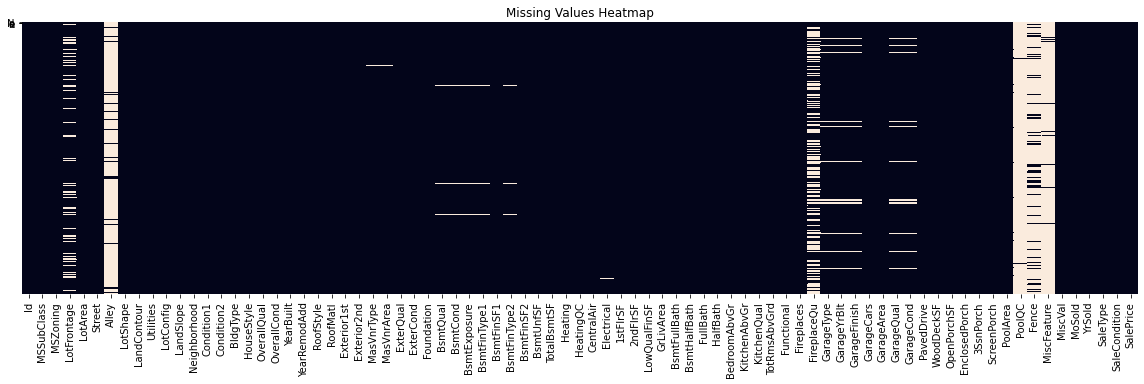

In [ ]:
plt.figure(figsize=(20,5))

sns.heatmap(data.isnull(), yticklabels="None", cbar=False)
plt.title("Missing Values Heatmap")

(1460, 75)


Text(0.5, 1.0, 'Missing Values Heatmap (after Dropping Columns)')

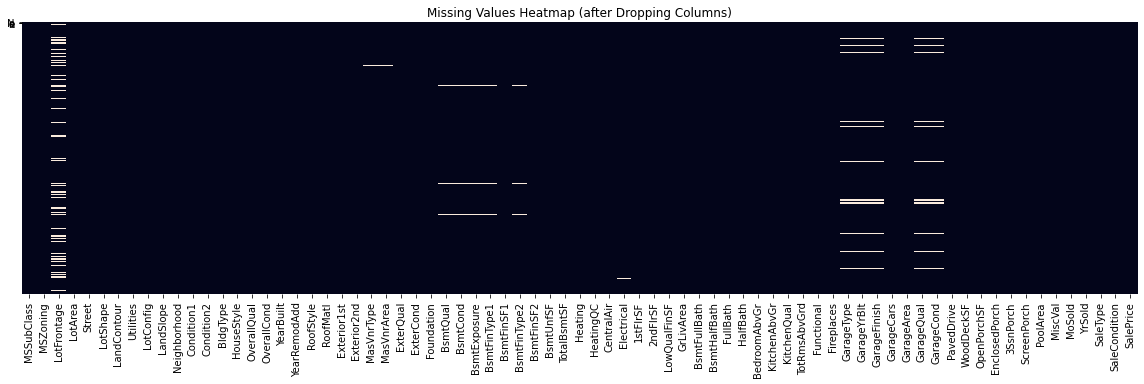

In [ ]:
data = data.drop(["Id", "MiscFeature", "Fence", "PoolQC", "FireplaceQu", "Alley"], axis=1)
print(data.shape)

plt.figure(figsize=(20,5))

sns.heatmap(data.isnull(), yticklabels="None", cbar=False)
plt.title("Missing Values Heatmap (after Dropping Columns)")

In [ ]:
#read feature documentation and identify features with ordinal data
ord_data = ["MSSubClass","LotShape","LandContour","LandSlope","OverallQual","OverallCond","ExterQual","ExterCond","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","HeatingQC","KitchenQual","GarageFinish","GarageQual","GarageCond","PavedDrive"]
non_ord, cat_data, num_data = list(), list(), list()

for i in data.columns:
    if i not in ord_data:
        non_ord.append(i)


for i in range(len(non_ord)):
    if data[non_ord[i]].dtypes == "object":
        cat_data.append(non_ord[i])
    else:
        num_data.append(non_ord[i])


print("Non-ordinal Features: ", len(non_ord), "Ordinal Features: ", len(ord_data), "Total Features: ", len(ord_data) + len(non_ord))
print("Categorical Features: ", len(cat_data), "Continuous Features: ", len(num_data), "Ordinal Features: ", len(ord_data), "Total Features: ", len(ord_data) + len(cat_data) + len(num_data))

Non-ordinal Features:  56 Ordinal Features:  19 Total Features:  75
Categorical Features:  22 Continuous Features:  34 Ordinal Features:  19 Total Features:  75


In [ ]:
fill = dict()

for i in range(len(data.columns)):
    
    if data.columns[i] in num_data:
        fill[data.columns[i]] = data[data.columns[i]].mean()
    
    else:
        fill[data.columns[i]] = str(data[data.columns[i]].mode()).split()[1]
        
print(len(fill))

75


Text(0.5, 1.0, 'Missing Values Heatmap (after filling with mode)')

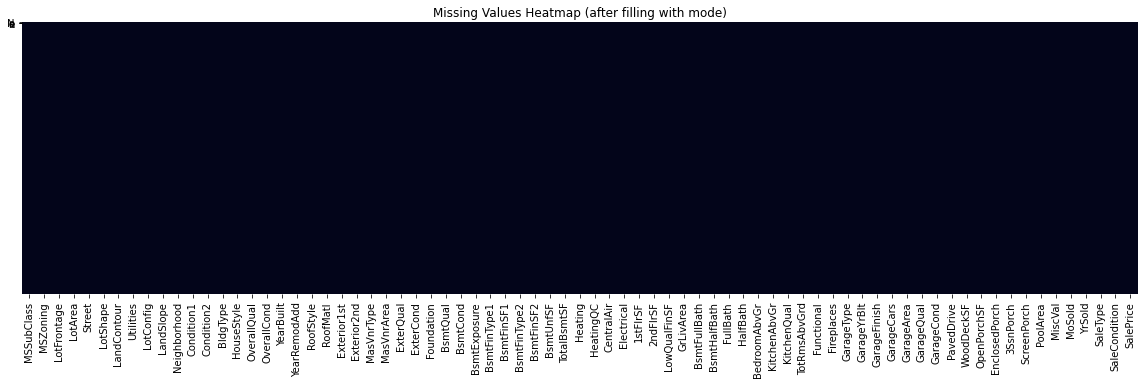

In [ ]:
data = data.fillna(value=fill)

plt.figure(figsize=(20,5))

sns.heatmap(data.isnull(), yticklabels="None", cbar=False)
plt.title("Missing Values Heatmap (after filling with mode)")

### Encoding Categorical Data

In [ ]:
df = data.drop(["SalePrice"], axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal


In [ ]:
col_tr = make_column_transformer((OrdinalEncoder(), ord_data),(OneHotEncoder(), cat_data), remainder="passthrough")
df = col_tr.fit_transform(df)

print(df.shape)

(1460, 217)


In [ ]:
final_data = pd.DataFrame(df)
final_data["SalePrice"] = data.SalePrice

print(final_data.shape)
final_data.tail()

(1460, 218)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,SalePrice
1455,5.0,3.0,3.0,0.0,5.0,4.0,3.0,4.0,2.0,3.0,3.0,5.0,5.0,0.0,3.0,1.0,4.0,4.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,62.0,7917.0,1999.0,2000.0,0.0,0.0,0.0,953.0,953.0,953.0,694.0,0.0,1647.0,0.0,0.0,2.0,1.0,3.0,1.0,7.0,1.0,1999.0,2.0,460.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,8.0,2007.0,175000
1456,0.0,3.0,3.0,0.0,5.0,5.0,3.0,4.0,2.0,3.0,3.0,0.0,4.0,4.0,3.0,2.0,4.0,4.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,85.0,13175.0,1978.0,1988.0,119.0,790.0,163.0,589.0,1542.0,2073.0,0.0,0.0,2073.0,1.0,0.0,2.0,0.0,3.0,1.0,7.0,2.0,1978.0,2.0,500.0,349.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2010.0,210000
1457,6.0,3.0,3.0,0.0,6.0,8.0,0.0,2.0,3.0,1.0,3.0,2.0,5.0,0.0,2.0,1.0,4.0,4.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,66.0,9042.0,1941.0,2006.0,0.0,275.0,0.0,877.0,1152.0,1188.0,1152.0,0.0,2340.0,0.0,0.0,2.0,0.0,4.0,1.0,9.0,2.0,1941.0,1.0,252.0,0.0,60.0,0.0,0.0,0.0,0.0,2500.0,5.0,2010.0,266500
1458,0.0,3.0,3.0,0.0,4.0,5.0,3.0,4.0,3.0,3.0,2.0,2.0,4.0,2.0,2.0,2.0,4.0,4.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,68.0,9717.0,1950.0,1996.0,0.0,49.0,1029.0,0.0,1078.0,1078.0,0.0,0.0,1078.0,1.0,0.0,1.0,0.0,2.0,1.0,5.0,0.0,1950.0,1.0,240.0,366.0,0.0,112.0,0.0,0.0,0.0,0.0,4.0,2010.0,142125
1459,0.0,3.0,3.0,0.0,4.0,5.0,2.0,4.0,3.0,3.0,3.0,1.0,3.0,2.0,3.0,0.0,4.0,4.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,75.0,9937.0,1965.0,1965.0,0.0,830.0,290.0,136.0,1256.0,1256.0,0.0,0.0,1256.0,1.0,0.0,1.0,1.0,3.0,1.0,6.0,0.0,1965.0,1.0,276.0,736.0,68.0,0.0,0.0,0.0,0.0,0.0,6.0,2008.0,147500


### Feature Scaling – Standardization

In [ ]:
scaler = StandardScaler() #switched to a robust scaler due to the possibility of data outliers
X = scaler.fit_transform(final_data)

print(X.shape)

(1460, 218)


In [ ]:
final_data = pd.DataFrame(X)
final_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217
0,0.200350,0.750731,0.314667,-0.225716,0.651479,-0.517200,-0.777976,0.364207,-0.324152,0.281048,0.628912,-0.429918,0.307315,-0.884658,-0.409369,-0.281887,0.215646,0.186019,0.289745,-0.083045,-0.215859,-0.105263,0.518133,-0.418955,-0.064238,0.064238,0.02618,-0.02618,-0.468739,-0.262324,-0.182380,-0.052414,0.622762,-0.10854,-0.037037,-0.105263,-0.203395,-0.139832,2.955221,-0.190252,...,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995,-0.229372,-0.207142,1.050994,0.878668,0.511418,0.575425,-0.288653,-0.944591,-0.459303,-0.793434,1.161852,-0.120242,0.370333,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,0.912210,-0.951226,1.021157,0.311725,0.351000,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,0.347273
1,-1.001421,0.750731,0.314667,-0.225716,-0.071836,2.179628,0.663451,0.364207,-0.324152,0.281048,-1.128430,-1.518697,0.307315,-0.884658,0.795629,-0.281887,0.215646,0.186019,0.289745,-0.083045,-0.215859,-0.105263,0.518133,-0.418955,-0.064238,0.064238,0.02618,-0.02618,-0.468739,-0.262324,5.483049,-0.052414,-1.605749,-0.10854,-0.037037,-0.105263,-0.203395,-0.139832,-0.338384,-0.190252,...,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995,0.451936,-0.091886,0.156734,-0.429577,-0.574410,1.171992,-0.288653,-0.641228,0.466465,0.257140,-0.795163,-0.120242,-0.482512,-0.819964,3.948809,0.789741,-0.761621,0.163779,-0.211454,-0.318683,0.600495,-0.104483,0.311725,-0.060731,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,0.007288
2,0.200350,-1.378933,0.314667,-0.225716,0.651479,-0.517200,-0.777976,0.364207,-0.324152,0.281048,-0.249759,-0.429918,0.307315,-0.884658,-0.409369,-0.281887,0.215646,0.186019,0.289745,-0.083045,-0.215859,-0.105263,0.518133,-0.418955,-0.064238,0.064238,0.02618,-0.02618,-0.468739,-0.262324,-0.182380,-0.052414,0.622762,-0.10854,-0.037037,-0.105263,-0.203395,-0.139832,2.955221,-0.190252,...,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995,-0.093110,0.073480,0.984752,0.830215,0.323060,0.092907,-0.288653,-0.301643,-0.313369,-0.627826,1.189351,-0.120242,0.515013,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,-0.318683,0.600495,0.937776,0.311725,0.631726,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,0.536154
3,0.440704,-1.378933,0.314667,-0.225716,0.651479,-0.517200,0.663451,0.364207,0.832969,-2.792584,0.628912,-1.518697,0.307315,0.265476,-0.409369,0.950313,0.215646,0.186019,0.289745,-0.083045,-0.215859,-0.105263,0.518133,-0.418955,-0.064238,0.064238,0.02618,-0.02618,2.133385,-0.262324,-0.182380,-0.052414,-1.605749,-0.10854,-0.037037,-0.105263,-0.203395,-0.139832,-0.338384,5.256182,...,3.668167,-0.052414,-0.091035,-0.117851,-2.138345,-0.305995,-0.456474,-0.096897,-1.863632,-0.720298,-0.574410,-0.499274,-0.288653,-0.061670,-0.687324,-0.521734,0.937276,-0.120242,0.383659,1.107810,-0.241061,-1.026041,-0.761621,0.163779,-0.211454,0.296763,0.600495,0.812705,1.650307,0.790804,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,-0.515281
4,0.200350,-1.378933,0.314667,-0.225716,1.374795,-0.517200,-0.777976,0.364207,-0.324152,0.281048,-2.007101,-0.429918,0.307315,-0.884658,-0.409369,-0.281887,0.215646,0.186019,0.289745,-0.083045,-0.215859,-0.105263,0.518133,-0.418955,-0.064238,0.064238,0.02618,-0.02618,-0.468739,-0.262324,5.483049,-0.052414,-1.605749,-0.10854,-0.037037,-0.105263,-0.203395,-0.139832,-0.338384,-0.190252,...,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995,0.633618,0.375148,0.951632,0.733308,1.364570,0.463568,-0.288653,-0.174865,0.199680,-0.045611,1.617877,-0.120242,1.299326,1.107810,-0.241061,0.789741,1.227585,1.390023,-0.211454,1.527656,0.

### Data Outliers – Isolation Forests

In [ ]:
anomalies = IsolationForest(contamination=0.05).fit_predict(final_data)
print("Rows with anomalies: ", np.where(anomalies<1))

Rows with anomalies:  (array([   8,    9,   11,   30,   52,   88,   93,  108,  113,  144,  155,
        185,  188,  246,  325,  335,  350,  358,  375,  383,  389,  398,
        417,  440,  488,  495,  515,  523,  529,  531,  533,  574,  583,
        630,  635,  636,  649,  676,  691,  705,  711,  747,  749,  769,
        798,  803,  809,  812,  825,  828,  845,  898,  916,  944, 1000,
       1046, 1100, 1163, 1169, 1181, 1182, 1186, 1228, 1230, 1266, 1298,
       1328, 1337, 1387, 1423, 1437, 1443, 1449]),)


In [ ]:
final_data = final_data.drop(np.where(anomalies<1)[0])
final_data.shape

(1387, 218)

### Dimensionality Reduction – PCA

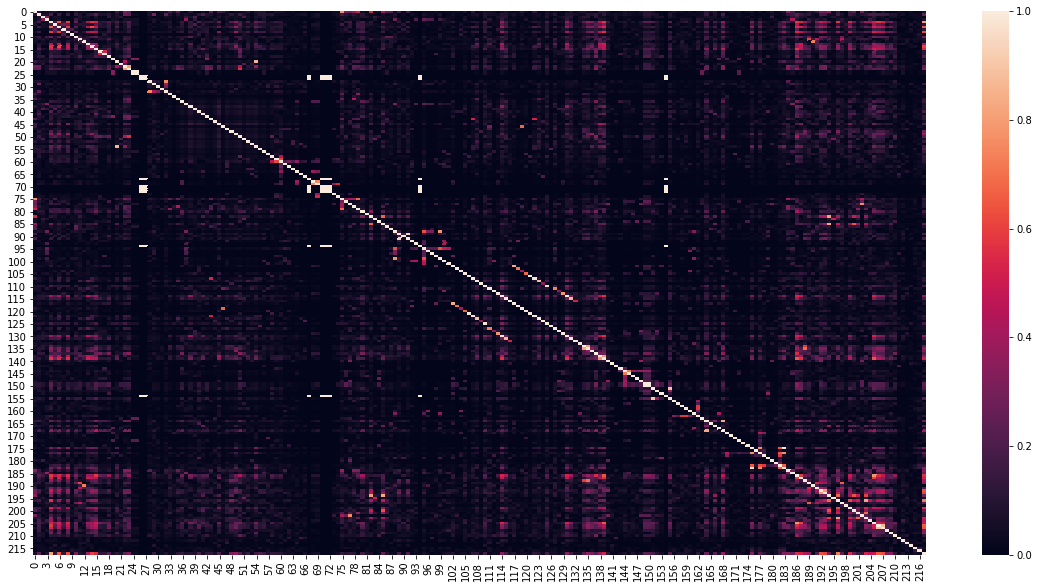

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(final_data.corr().abs())

In [ ]:
X = final_data.drop([217], axis=1)
y = final_data[217]

print(X.shape, y.shape)

(1387, 217) (1387,)


(Text(0, 0.5, 'Explained Variance'), Text(0.5, 0, 'N-Components'))

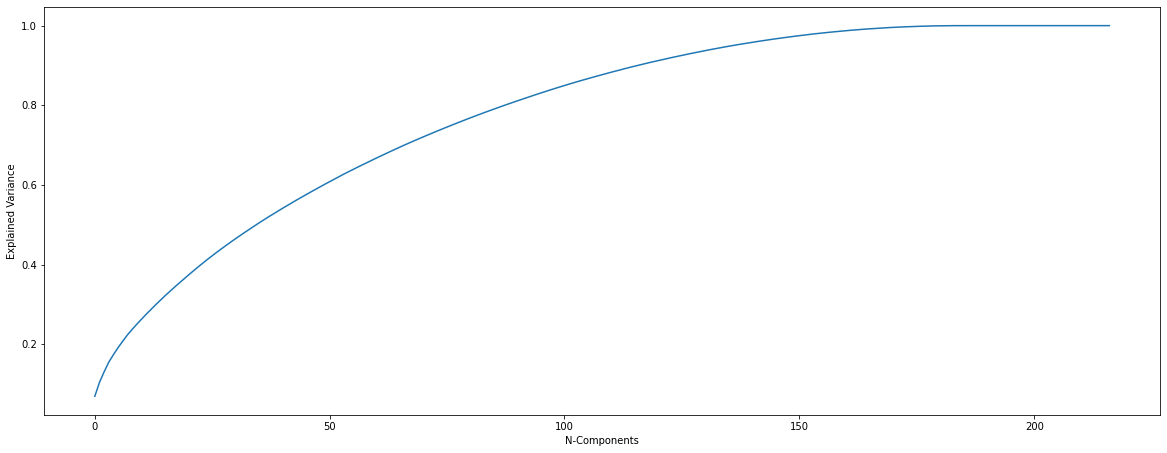

In [ ]:
pca = PCA().fit(X)
variance = pca.explained_variance_ratio_
components = np.arange(len(variance))

plt.figure(figsize=(20,7.5))
plt.plot(components, np.cumsum(variance))
plt.ylabel("Explained Variance"), plt.xlabel("N-Components")

In [ ]:
pca = PCA(n_components=100).fit(X)
X = pca.transform(X)

print("Total Explained Variance: ", np.cumsum(pca.explained_variance_ratio_)[-1])
X.shape

Total Explained Variance:  0.8437716880859238


(1387, 100)

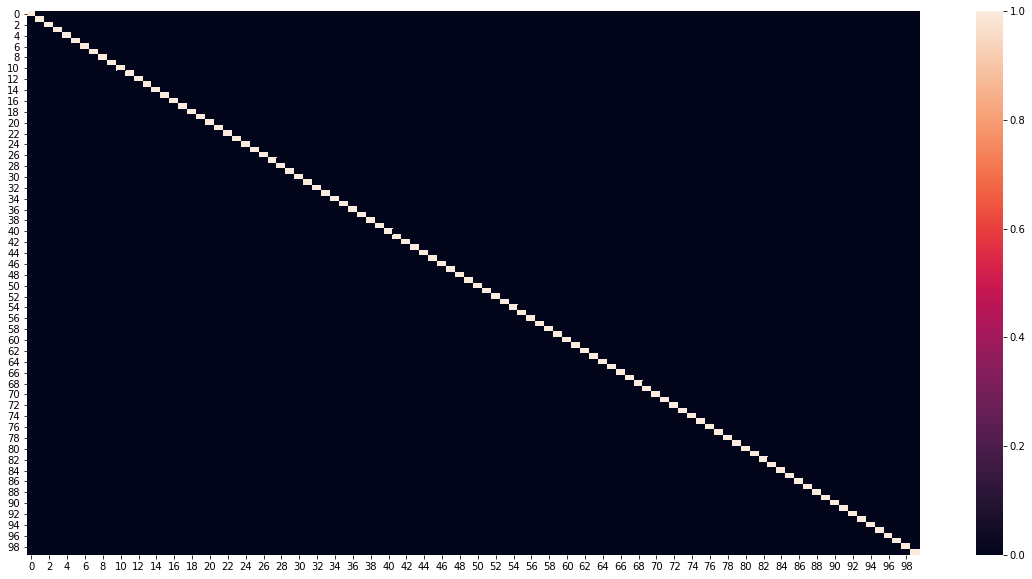

In [ ]:
final_data = pd.DataFrame(X)
plt.figure(figsize=(20,10))
sns.heatmap(final_data.corr().abs())

## Machine Learning Modeling


### Cross-Validated Modeling

1. **Linear Regression Models:** LinearRegression, Lasso, Ridge, *KernelRidge*
2. **Tree-Based Regression Models:** RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
3. **Ensemble Regression Models:** LinearSVR, SVR, NuSVR, *KernelRidge*

In [ ]:
pipe = make_pipeline(PolynomialFeatures(degree=1), LinearRegression())
scores = cross_val_score(pipe, X, y, cv=10, scoring="r2")

print(scores, scores.mean())

[ 0.84634328  0.89599879  0.90033323  0.88181627  0.89289101  0.88559412
  0.87724061  0.845413    0.86314556 -2.3130895 ] 0.5575686385445445


In [ ]:
pipe = make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=0.015))
scores = cross_val_score(pipe, X, y, cv=10, scoring="r2")

print(scores, scores.mean())

[0.92743014 0.91427305 0.92892512 0.87425372 0.89211099 0.90078303
 0.90391274 0.88619814 0.90901714 0.89445553] 0.9031359588334485


In [ ]:
pipe = make_pipeline(PolynomialFeatures(degree=1), Ridge(alpha=100))
scores = cross_val_score(pipe, X, y, cv=10, scoring="r2")

print(scores, scores.mean())

[0.8954399  0.89910144 0.90359292 0.88507923 0.89218393 0.8912835
 0.88289678 0.84741249 0.88336191 0.86412632] 0.8844478424271335


In [ ]:
model = RandomForestRegressor(n_estimators=100)
scores = cross_val_score(model, X, y, cv=10, scoring="r2")

print(scores, scores.mean())

[0.86301182 0.86445587 0.88602774 0.83494835 0.83148194 0.87341495
 0.86858485 0.83798595 0.82815319 0.8673498 ] 0.8555414444133203


In [ ]:
model = AdaBoostRegressor(n_estimators=100, learning_rate=1, loss="linear")
scores = cross_val_score(model, X, y, cv=10, scoring="r2")

print(scores, scores.mean())

[0.80383001 0.82168276 0.83340201 0.81090287 0.81091839 0.81872247
 0.79414215 0.76521545 0.78393964 0.78509148] 0.8027847244268014


In [ ]:
model = BaggingRegressor(n_estimators=100, max_samples=1.0, max_features=1.0)
scores = cross_val_score(model, X, y, cv=10, scoring="r2")

print(scores, scores.mean())

[0.86213021 0.86403529 0.8921901  0.83769453 0.83863697 0.86921489
 0.86530443 0.83224304 0.8335452  0.86678656] 0.8561781219393472


In [ ]:
model = LinearSVR(C=1, max_iter=1000).fit(X_train, y_train)
scores = cross_val_score(model, X, y, cv=10, scoring="r2")

print(scores, scores.mean())

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

[ 0.87388269  0.88772758  0.89412864  0.88134195  0.87438199  0.89824131
  0.84221447  0.83455606  0.83980737 -0.39896469] 0.7427317383827574


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
model = SVR(C=1,kernel="poly", degree=3)
scores = cross_val_score(model, X, y, cv=10, scoring="r2")

print(scores, scores.mean())

[0.82977841 0.8643365  0.87125055 0.8377506  0.80668411 0.85091005
 0.90561878 0.88072258 0.82045567 0.85742634] 0.852493357446605


In [ ]:
model = NuSVR(C=1,kernel="poly", degree=3)
scores = cross_val_score(model, X, y, cv=10, scoring="r2")

print(scores, scores.mean())

[0.82762068 0.86386384 0.8749153  0.84115519 0.808505   0.85545803
 0.90684707 0.88257975 0.80947391 0.85769817] 0.8528116948827826


In [ ]:
model = KernelRidge(alpha=1, kernel="poly", degree=3)
scores = cross_val_score(model, X, y, cv=10, scoring="r2")

print(scores, scores.mean())

[0.92570923 0.89511924 0.92685737 0.891806   0.89741489 0.8881654
 0.90996948 0.89410554 0.91701873 0.89876315] 0.9044929031135766


### Hyperparameter Tuning

Focus on **KernelRidge**, **Lasso**, and **Ridge** models based on cross-vaidation accuracy

#### Lasso Regression

In [ ]:
alphas = [0.01, 0.05, 0.1, 0.5, 1]
degrees = [1,2]
param_grid = dict(polynomialfeatures__degree = degrees, lasso__alpha = alphas)
print(param_grid)

{'polynomialfeatures__degree': [1, 2], 'lasso__alpha': [0.01, 0.05, 0.1, 0.5, 1]}


In [ ]:
model = make_pipeline(PolynomialFeatures(), Lasso())
reg = GridSearchCV(model, param_grid, cv=10, scoring="r2")
reg.fit(X,y)

print(reg.best_score_, reg.best_params_)

0.8925957557470963 {'lasso__alpha': 0.05, 'polynomialfeatures__degree': 2}


(Text(0, 0.5, 'R2 Score'),
 Text(0.5, 0, 'Alpha – Regularization Parameter'),
 <matplotlib.legend.Legend at 0x7f4bdbcc8128>)

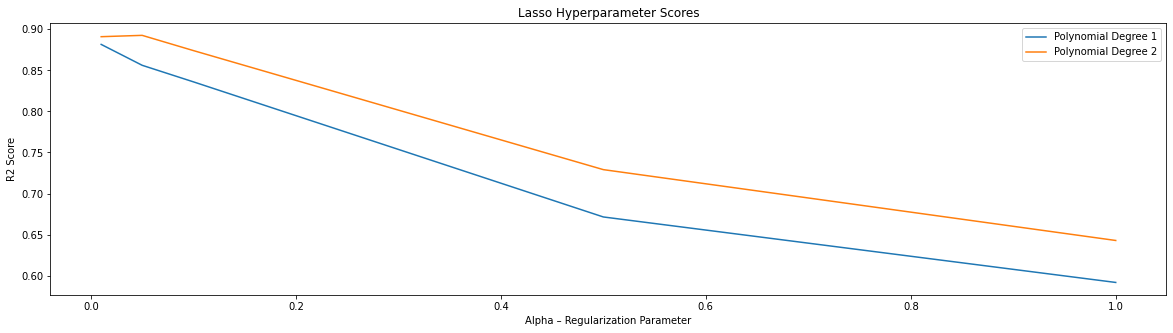

In [ ]:
plt.figure(figsize=(20,5))

plt.plot(reg.cv_results_['param_lasso__alpha'][::2].data, reg.cv_results_['mean_test_score'][::2].data, label="Polynomial Degree 1")
plt.plot(reg.cv_results_['param_lasso__alpha'][1::2].data, reg.cv_results_['mean_test_score'][1::2].data, label="Polynomial Degree 2")

plt.title("Lasso Hyperparameter Scores")
plt.ylabel("R2 Score"), plt.xlabel("Alpha – Regularization Parameter"), plt.legend()

In [ ]:
#focus on the second polynomial and alpha value between 0 and 0.015
param_grid = dict(lasso__alpha = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05])
reg = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), Lasso()), param_grid, cv=10, scoring="r2").fit(X,y)
print(reg.best_score_, reg.best_params_)

0.89728824897708 {'lasso__alpha': 0.035}


(Text(0.5, 1.0, 'Lasso Hyperparameter Scores'),
 Text(0, 0.5, 'R2 Score'),
 Text(0.5, 0, 'Alpha'))

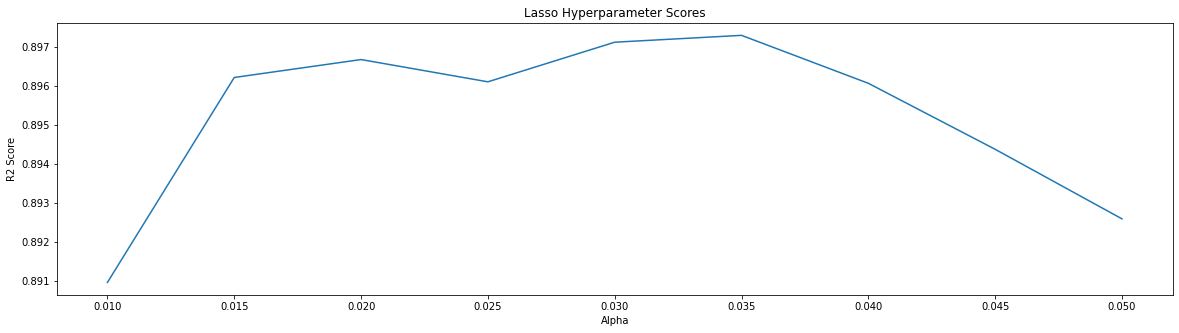

In [ ]:
plt.figure(figsize=(20,5))

plt.plot(reg.cv_results_['param_lasso__alpha'].data, reg.cv_results_['mean_test_score'].data)
plt.title("Lasso Hyperparameter Scores"), plt.ylabel("R2 Score"), plt.xlabel("Alpha – Regularization Parameter")

**Lasso Hyperparameters:** Alpha = 0.035, Polynomial Degree = 2, Other Parameters = Default | **R2 Score = 0.8973**

#### Kernel Ridge Regression

In [ ]:
alphas = [0, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
degrees = [1,2,3,4,5]
param_grid = dict(degree = degrees, alpha = alphas)
print(param_grid)

{'degree': [1, 2, 3, 4, 5], 'alpha': [0, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]}


In [ ]:
model = KernelRidge(kernel="poly")
reg = GridSearchCV(model, param_grid, cv=10, scoring="r2")
reg.fit(X,y)

print(reg.best_score_, reg.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.p

0.9084319161476909 {'alpha': 5, 'degree': 2}


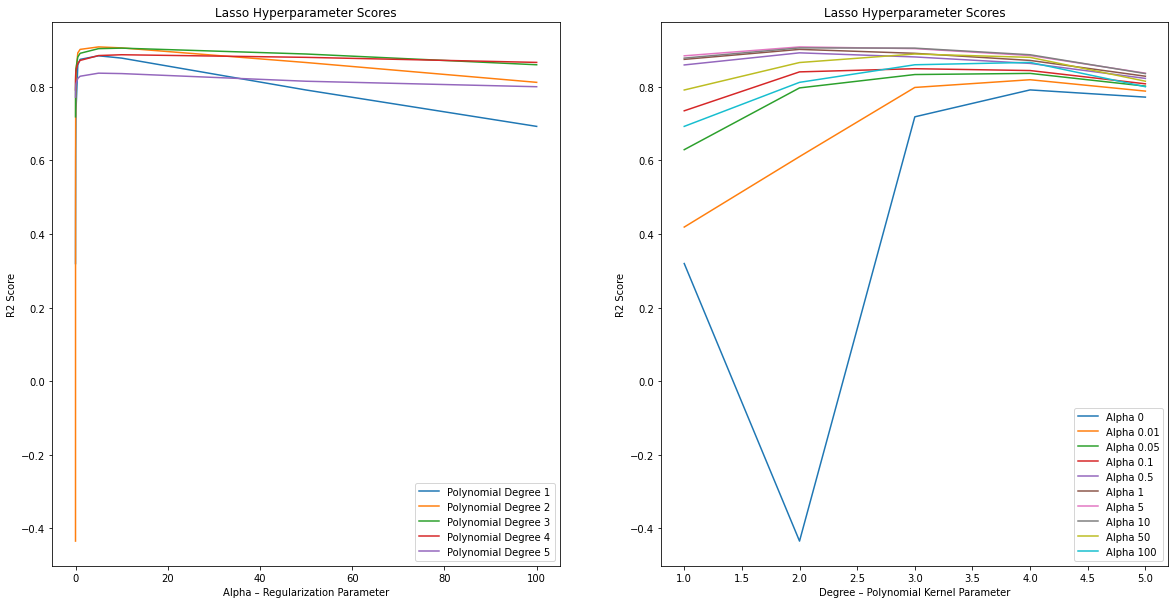

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(reg.cv_results_['param_alpha'][::5].data, reg.cv_results_['mean_test_score'][::5].data, label="Polynomial Degree 1")
plt.plot(reg.cv_results_['param_alpha'][1::5].data, reg.cv_results_['mean_test_score'][1::5].data, label="Polynomial Degree 2")
plt.plot(reg.cv_results_['param_alpha'][2::5].data, reg.cv_results_['mean_test_score'][2::5].data, label="Polynomial Degree 3")
plt.plot(reg.cv_results_['param_alpha'][3::5].data, reg.cv_results_['mean_test_score'][3::5].data, label="Polynomial Degree 4")
plt.plot(reg.cv_results_['param_alpha'][4::5].data, reg.cv_results_['mean_test_score'][4::5].data, label="Polynomial Degree 5")
plt.title("Kernel Ridge Hyperparameter Scores")
plt.xlabel("Alpha – Regularization Parameter")
plt.ylabel("R2 Score")
plt.legend()

plt.subplot(1,2,2)
plt.plot(reg.cv_results_['param_degree'][:5].data, reg.cv_results_['mean_test_score'][:5].data, label="Alpha 0")
plt.plot(reg.cv_results_['param_degree'][5:10].data, reg.cv_results_['mean_test_score'][5:10].data, label="Alpha 0.01")
plt.plot(reg.cv_results_['param_degree'][10:15].data, reg.cv_results_['mean_test_score'][10:15].data, label="Alpha 0.05")
plt.plot(reg.cv_results_['param_degree'][15:20].data, reg.cv_results_['mean_test_score'][15:20].data, label="Alpha 0.1")
plt.plot(reg.cv_results_['param_degree'][20:25].data, reg.cv_results_['mean_test_score'][20:25].data, label="Alpha 0.5")
plt.plot(reg.cv_results_['param_degree'][25:30].data, reg.cv_results_['mean_test_score'][25:30].data, label="Alpha 1")
plt.plot(reg.cv_results_['param_degree'][30:35].data, reg.cv_results_['mean_test_score'][30:35].data, label="Alpha 5")
plt.plot(reg.cv_results_['param_degree'][35:40].data, reg.cv_results_['mean_test_score'][35:40].data, label="Alpha 10")
plt.plot(reg.cv_results_['param_degree'][40:45].data, reg.cv_results_['mean_test_score'][40:45].data, label="Alpha 50")
plt.plot(reg.cv_results_['param_degree'][45:].data, reg.cv_results_['mean_test_score'][45:].data, label="Alpha 100")
plt.title("Kernerl. Ridge Hyperparameter Scores")
plt.xlabel("Degree – Polynomial Kernel Parameter")
plt.ylabel("R2 Score")
plt.legend()

plt.show()

In [ ]:
#focus on the second and third polynomials and alpha value between 0 and 10
param_grid = dict(alpha = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], degree=[2,3])
reg = GridSearchCV(KernelRidge(kernel="poly"), param_grid, cv=10, scoring="r2").fit(X,y)
print(reg.best_score_, reg.best_params_)

0.9085020030706815 {'alpha': 4, 'degree': 2}


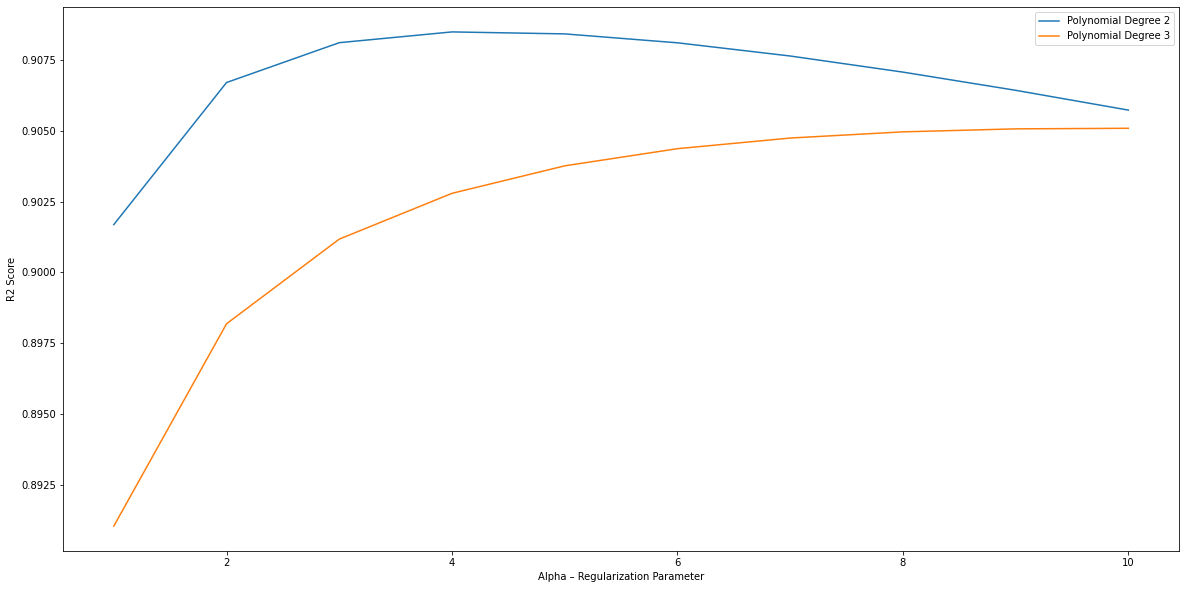

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(reg.cv_results_['param_alpha'][::2].data, reg.cv_results_['mean_test_score'][::2].data, label="Polynomial Degree 2")
plt.plot(reg.cv_results_['param_alpha'][1::2].data, reg.cv_results_['mean_test_score'][1::2].data, label="Polynomial Degree 3")

plt.xlabel("Alpha – Regularization Parameter"), plt.ylabel("R2 Score"), plt.legend()
plt.show()

**Kernel Ridge Hyperparameters:** Alpha = 4, Polynomial Degree = 2, Other Parameters = Default | **R2 Score = 0.9085**

#### Ridge Regression

In [ ]:
alphas = [10, 50, 100, 500, 1000]
degrees = [1,2]
param_grid = dict(polynomialfeatures__degree = degrees, ridge__alpha = alphas)
print(param_grid)

{'polynomialfeatures__degree': [1, 2], 'ridge__alpha': [10, 50, 100, 500, 1000]}


In [ ]:
model = make_pipeline(PolynomialFeatures(), Ridge())
reg = GridSearchCV(model, param_grid, cv=10, scoring="r2")
reg.fit(X,y)

print(reg.best_score_, reg.best_params_)

0.8842335482768059 {'polynomialfeatures__degree': 1, 'ridge__alpha': 500}


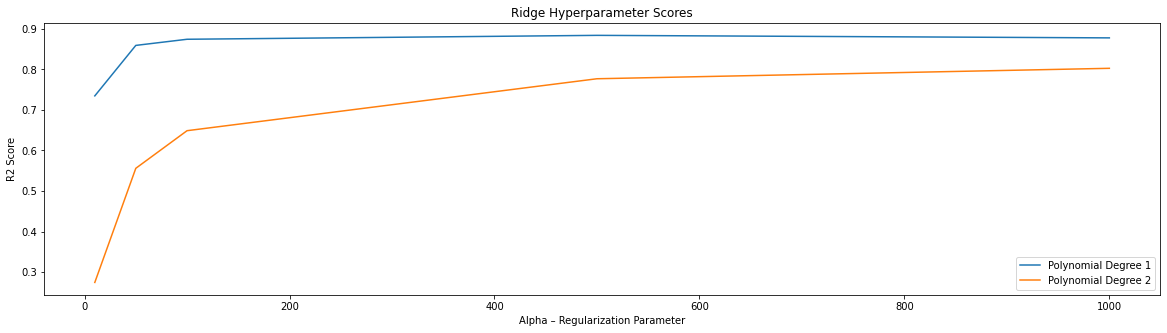

In [ ]:
plt.figure(figsize=(20,5))

plt.plot(reg.cv_results_['param_ridge__alpha'][:5].data, reg.cv_results_['mean_test_score'][:5].data, label="Polynomial Degree 1")
plt.plot(reg.cv_results_['param_ridge__alpha'][5:].data, reg.cv_results_['mean_test_score'][5:].data, label="Polynomial Degree 2")

plt.title("Ridge Hyperparameter Scores")
plt.ylabel("R2 Score"), plt.xlabel("Alpha – Regularization Parameter"), plt.legend()
plt.show()

In [ ]:
#focus on the first polynomial and alpha values between 100 and 1000
param_grid = dict(ridge__alpha = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000])
reg = GridSearchCV(make_pipeline(PolynomialFeatures(degree=1), Ridge()), param_grid, cv=10, scoring="r2").fit(X,y)
print(reg.best_score_, reg.best_params_)

0.8845319536041243 {'ridge__alpha': 400}


(Text(0.5, 1.0, 'Ridge Hyperparameter Scores'),
 Text(0, 0.5, 'R2 Score'),
 Text(0.5, 0, 'Alpha – Regularization Parameter'))

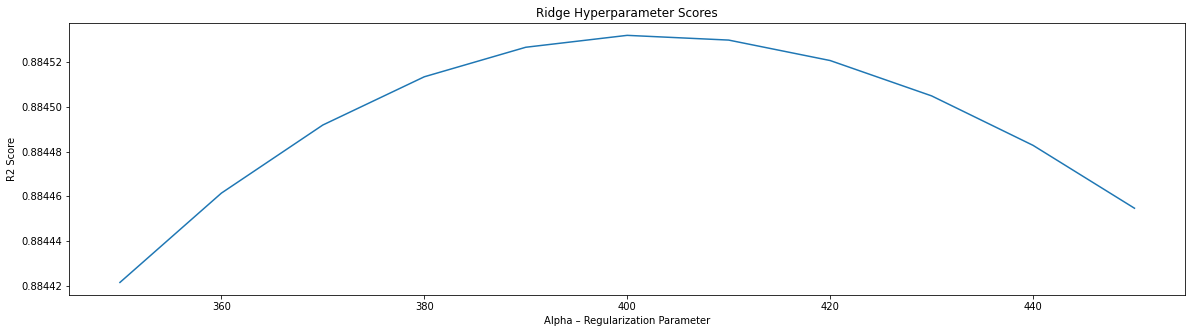

In [ ]:
plt.figure(figsize=(20,5))

plt.plot(reg.cv_results_['param_ridge__alpha'].data, reg.cv_results_['mean_test_score'].data)
plt.title("Ridge Hyperparameter Scores"), plt.ylabel("R2 Score"), plt.xlabel("Alpha – Regularization Parameter")

**Ridge Hyperparameters:** Alpha = 400, Polynomial Degree = 1, Other Parameters = Default | ***R2 Score = 0.88453*** 

### Model Evaluation
Based on hyperparameter tuning results, **Kernel Ridge** is the optimal model given its ***high R2 score***.

#### Model Score Optimization 

Text(0.5, 0, 'Alpha')

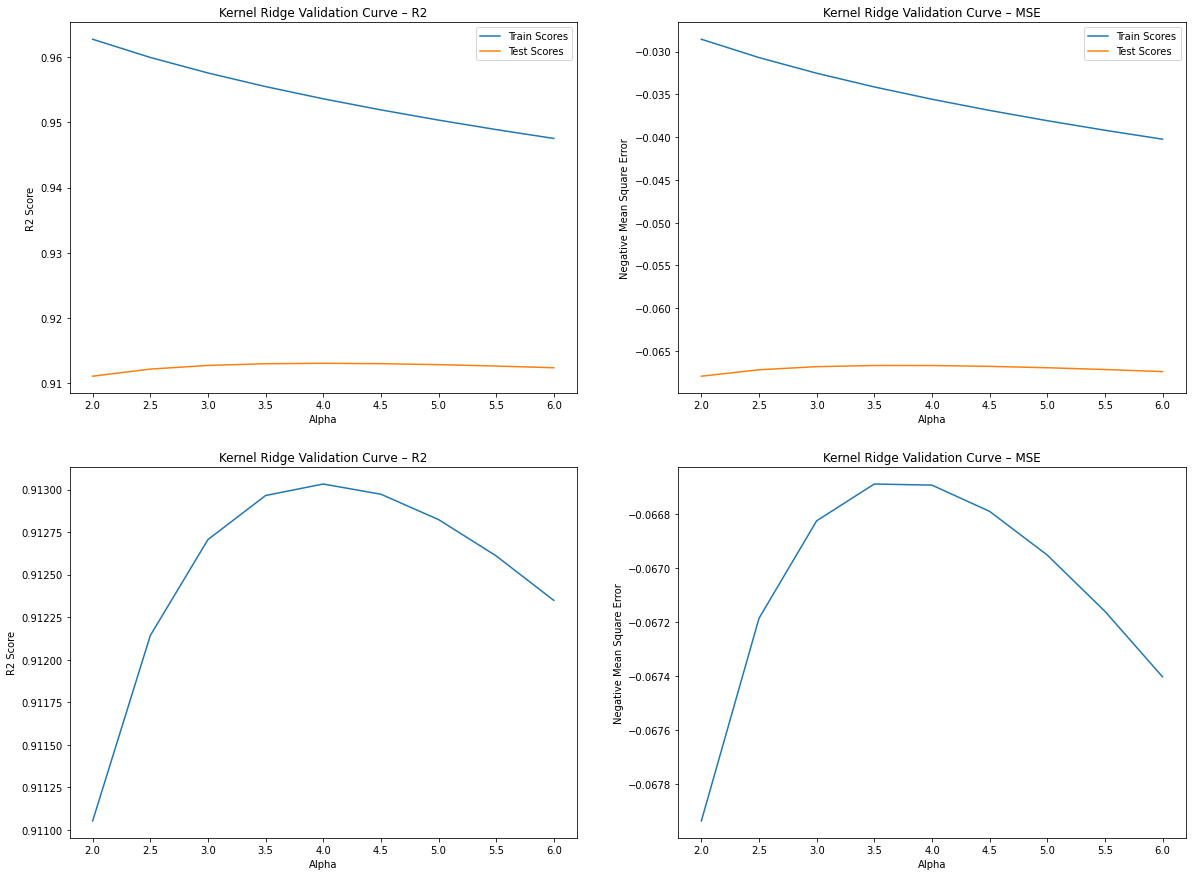

In [ ]:
alpha_range = [2,2.5,3,3.5,4,4.5,5,5.5,6]
r2_train, r2_test = validation_curve(KernelRidge(kernel="poly", degree=2), X, y, param_name="alpha", param_range = alpha_range, cv=10, scoring="r2")
mse_train, mse_test = validation_curve(KernelRidge(kernel="poly", degree=2), X, y, param_name="alpha", param_range = alpha_range, cv=10, scoring="neg_mean_squared_error")

plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(alpha_range, r2_train.mean(axis=1), label="Train Scores")
plt.plot(alpha_range, r2_test.mean(axis=1), label="Test Scores")
plt.xlabel("Alpha"), plt.ylabel("R2 Score"), plt.legend()
plt.title("Kernel Ridge Validation Curve – R2")

plt.subplot(2, 2, 2)
plt.plot(alpha_range, mse_train.mean(axis=1), label="Train Scores")
plt.plot(alpha_range, mse_test.mean(axis=1), label="Test Scores")
plt.xlabel("Alpha"), plt.ylabel("Negative Mean Square Error"), plt.legend()
plt.title("Kernel Ridge Validation Curve – MSE")

plt.subplot(2, 2, 3)
plt.plot(alpha_range, r2_test.mean(axis=1))
plt.title("Kernel Ridge Validation Curve – R2")
plt.ylabel("R2 Score")
plt.xlabel("Alpha")

plt.subplot(2, 2, 4)
plt.plot(alpha_range, mse_test.mean(axis=1))
plt.title("Kernel Ridge Validation Curve – MSE")
plt.ylabel("Negative Mean Square Error")
plt.xlabel("Alpha")

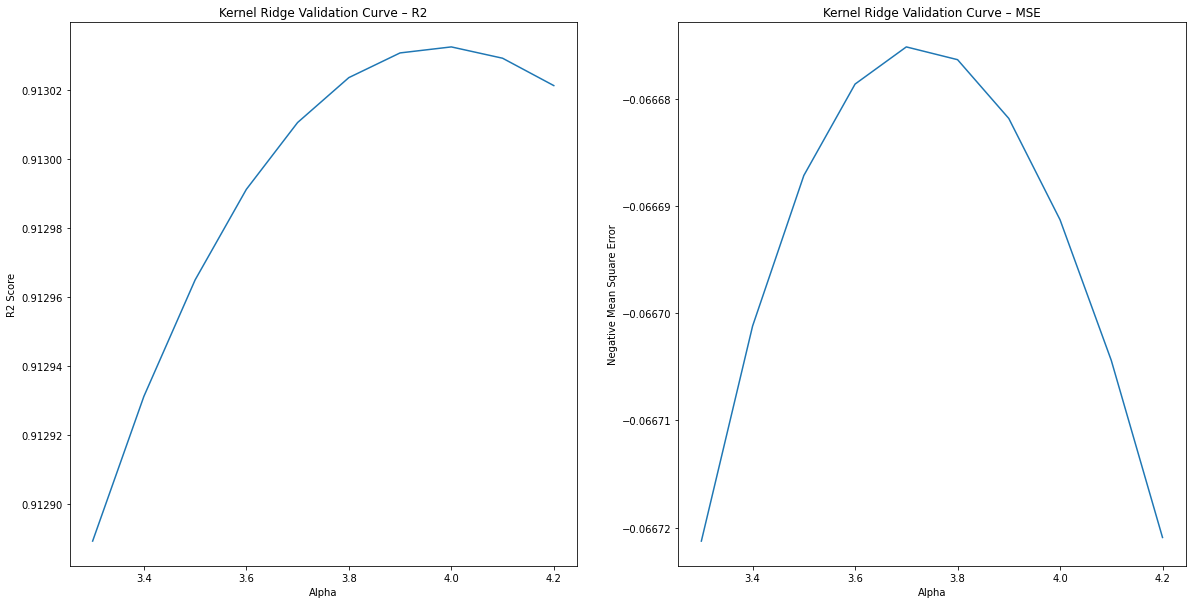

In [ ]:
alpha_range = [3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0,4.1,4.2]
r2_train, r2_test = validation_curve(KernelRidge(kernel="poly", degree=2), X, y, param_name="alpha", param_range = alpha_range, cv=10, scoring="r2")
mse_train, mse_test = validation_curve(KernelRidge(kernel="poly", degree=2), X, y, param_name="alpha", param_range = alpha_range, cv=10, scoring="neg_mean_squared_error")

plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.plot(alpha_range, r2_test.mean(axis=1))
plt.title("Kernel Ridge Validation Curve – R2")
plt.ylabel("R2 Score")
plt.xlabel("Alpha")

plt.subplot(1, 2, 2)
plt.plot(alpha_range, mse_test.mean(axis=1))
plt.title("Kernel Ridge Validation Curve – MSE")
plt.ylabel("Negative Mean Square Error")
plt.xlabel("Alpha")

plt.show()

R2 Score peaks at alpha 4.0, while means square error is minimal at alpha 3.7. We'll choose the midpoint between the two alphas for final modeling. Thus, **optimal alpha – 3.85**

#### Prediction Visualization

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1109, 100) (278, 100) (1109,) (278,)


In [ ]:
model = KernelRidge(kernel="poly", alpha=3.85, degree=2).fit(X_train, y_train)
y_pred = model.predict((X_test))

print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

0.06974733118318385
0.9247273248093899


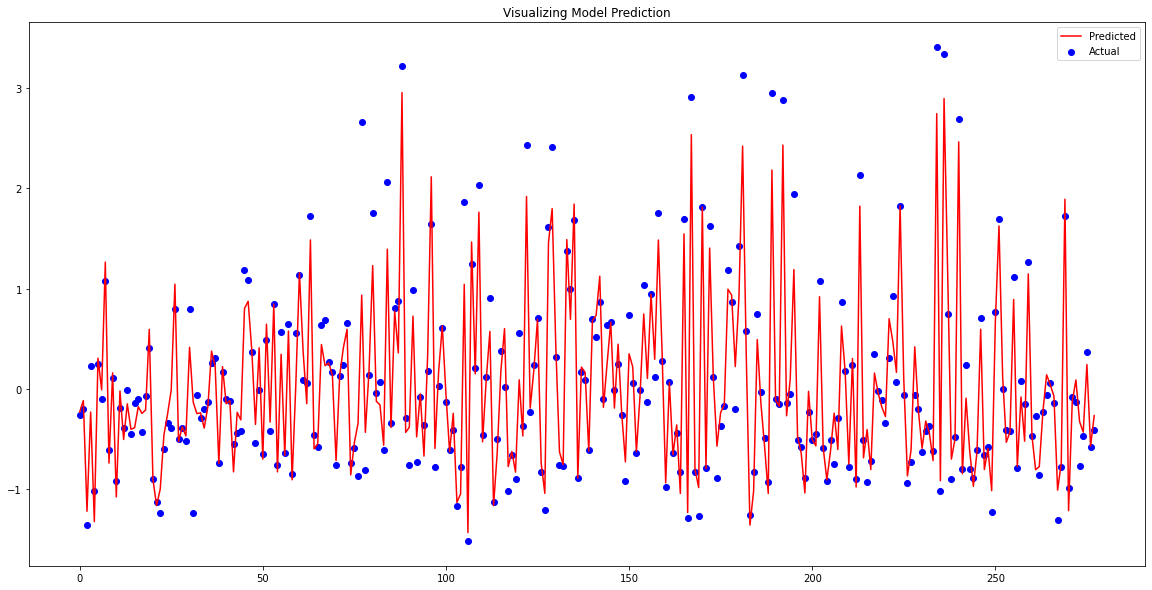

In [ ]:
x = np.arange(len(y_pred))
plt.figure(figsize=(20,10))

plt.plot(x, y_pred, label="Predicted", color="Red")
plt.scatter(x, y_test, label="Actual", color="Blue")
plt.title("Visualizing Model Prediction")
plt.legend()

plt.show()

#### Final Model Export

In [ ]:
final_model = KernelRidge(kernel="poly", alpha=3.85, degree=2).fit(X, y)

pickle.dump(final_model, open("boston_house_model", 'wb')) #save regression model
pickle.dump(scaler, open("boston_house_scaler", 'wb')) #save standard scaler
pickle.dump(pca, open("boston_house_pca", 'wb')) #save pca model

#Note that the data preparation pipeline also involved Missing Values Imputation and Categorical Columns Transformation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ResourceWarning: unclosed file <_io.BufferedWriter name='boston_house_model'>
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ResourceWarning: unclosed file <_io.BufferedWriter name='boston_house_scaler'>
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: ResourceWarning: unclosed file <_io.BufferedWriter name='boston_house_pca'>
  """
